## Airlines Passengers Forecasting

#### In This Notebook

* Airlines passengers dataset
* Exploratory data analysis 
* Simple Moving Average(SMA)
* Exponential Moving Average(EMA)
* Autoregressive Model(AR)
* Autoregressive Integrated Moving Average (ARIMA)
* Seasonal Autoregressive Integrated Moving-Average (SARIMA)

### Libraries

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore')

### The Data

In [2]:
df = pd.read_excel('Airlines+Data.xlsx',header=0,index_col=0,parse_dates=True)
df.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [3]:
df.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


### EDA

<AxesSubplot:xlabel='Month'>

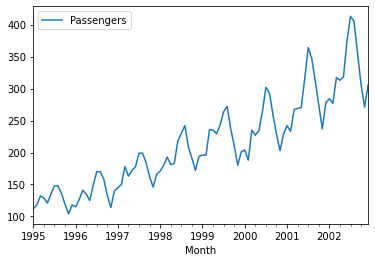

In [4]:
df.plot()

<AxesSubplot:ylabel='Count'>

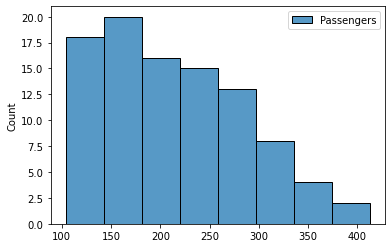

In [5]:
sns.histplot(df)

<AxesSubplot:xlabel='Passengers', ylabel='Count'>

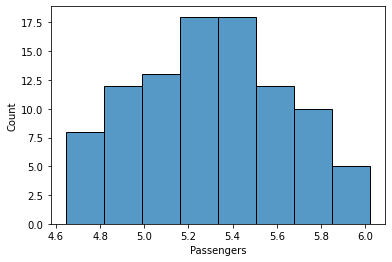

In [6]:
# log transformation
sns.histplot(np.log(df['Passengers']))

<AxesSubplot:ylabel='Density'>

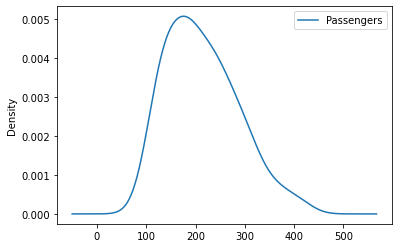

In [7]:
df.plot(kind='kde')

In [8]:
series = pd.read_excel('Airlines+Data.xlsx',header=0,index_col=0,parse_dates=True,squeeze=True)

<AxesSubplot:>

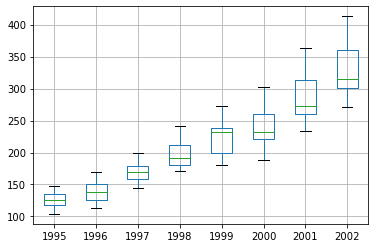

In [9]:
groups = series.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

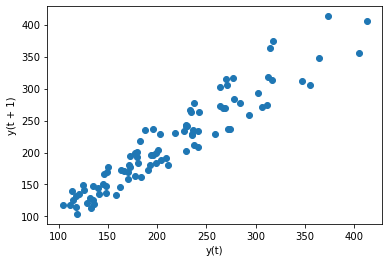

In [10]:
pd.plotting.lag_plot(df) # Lag plot

In [11]:
df.isna().sum() #check for null values

Passengers    0
dtype: int64

### Autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

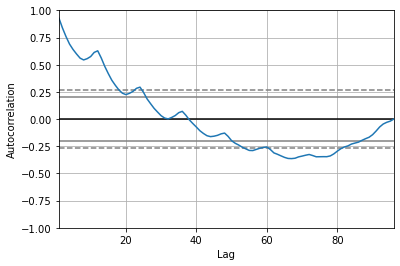

In [12]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Passengers'])

### AR Model

In [47]:
from statsmodels.tsa.ar_model import AutoReg

train_data = df['Passengers'][:len(df)-20]
test_data = df['Passengers'][len(df)-20:]

# Instantiate and fit the AR model with training data
ar_model = AutoReg(train_data, lags=8).fit()

# Print Summary
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:             Passengers   No. Observations:                   76
Model:                     AutoReg(8)   Log Likelihood                -292.410
Method:               Conditional MLE   S.D. of innovations             17.836
Date:                Fri, 19 Nov 2021   AIC                              6.057
Time:                        11:16:17   BIC                              6.383
Sample:                    09-01-1995   HQIC                             6.186
                         - 04-01-2001                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        10.6515     10.075      1.057      0.290      -9.095      30.398
Passengers.L1     1.0804      0.120      9.012      0.000       0.845       1.315
Passengers.L2    -0.3205      0.180     

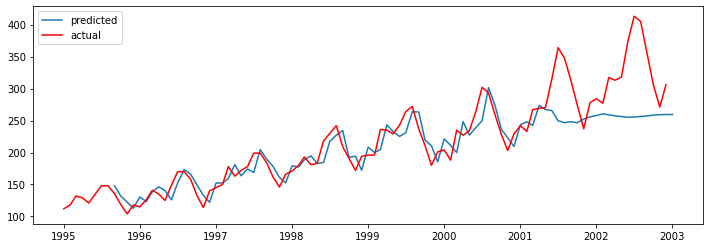

In [14]:
# Actual vs Predicted
pred = ar_model.predict(start=1, end=96, dynamic=False)
plt.figure(figsize=(12,4))
plt.plot(pred, label='predicted')
plt.plot(df['Passengers'], color='red', label='actual')
plt.legend();

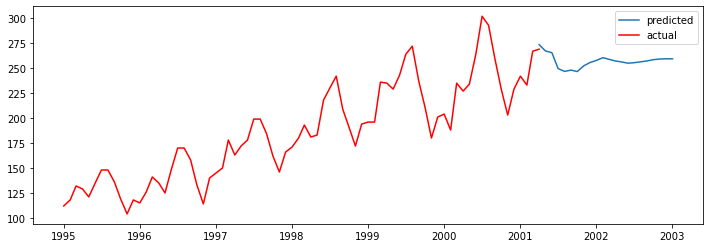

In [15]:
# Traind data and predicted test data
pred = ar_model.predict(start=75, end=96, dynamic=False)

plt.figure(figsize=(12,4))
plt.plot(pred, label='predicted')
plt.plot(train_data, color='red', label='actual')
plt.legend();

### Simple Moving Avarage(SMA)


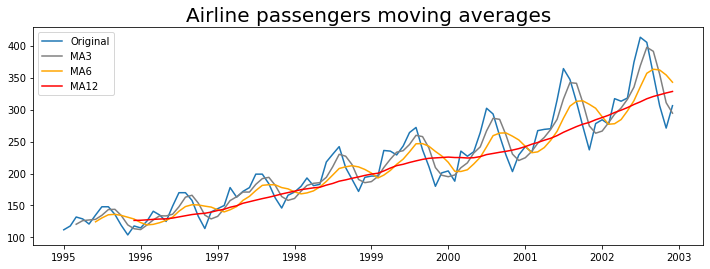

In [16]:
df['MA3'] = df['Passengers'].rolling(window=3).mean()
df['MA6'] = df['Passengers'].rolling(window=6).mean()
df['MA12'] = df['Passengers'].rolling(window=12).mean()

# Plot
plt.figure(figsize=(12,4))
plt.title('Airline passengers moving averages', size=20)
plt.plot(df['Passengers'], label='Original')
plt.plot(df['MA3'], color='gray', label='MA3')
plt.plot(df['MA6'], color='orange', label='MA6')
plt.plot(df['MA12'], color='red', label='MA12')
plt.legend();

### Exponantional weighted moving avarage(EWMA)


<AxesSubplot:xlabel='Month'>

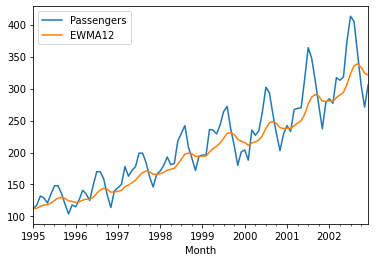

In [17]:
df['EWMA12']=df['Passengers'].ewm(span=12,adjust=False).mean()
df[['Passengers','EWMA12']].plot()

### Differencing
a method of transforming a time series 

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
adfuller(df['Passengers'])
# there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

(1.3402479596467032,
 0.9968250481137263,
 12,
 83,
 {'1%': -3.5117123057187376,
  '5%': -2.8970475206326833,
  '10%': -2.5857126912469153},
 626.0084713813505)

In [20]:
df['Passengers First Difference'] = df['Passengers'] - df['Passengers'].shift(1)

df['Seasonal First Difference']=df['Passengers']-df['Passengers'].shift(12)

In [21]:
adfuller(df['Seasonal First Difference'].dropna()) #Stationary as p value is near to 0.05

(-2.6900043838623167,
 0.07578397625851754,
 1,
 82,
 {'1%': -3.512738056978279,
  '5%': -2.8974898650628984,
  '10%': -2.585948732897085},
 531.1060746991411)

<AxesSubplot:xlabel='Month'>

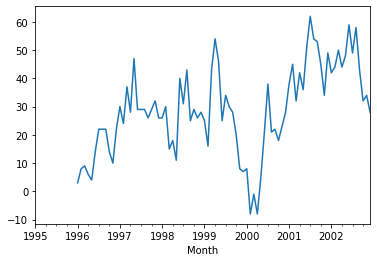

In [22]:
df['Seasonal First Difference'].plot()

### ARMA

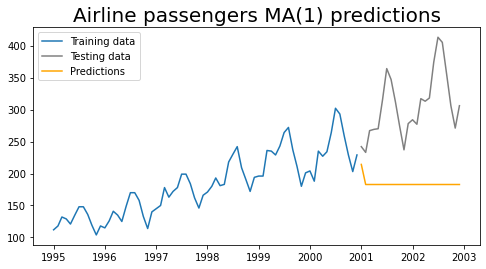

In [29]:
from statsmodels.tsa.arima_model import ARMA

# Train/test split
df_train = df[:-24]
df_test = df[-24:]

# Train the model
model = ARMA(df_train['Passengers'], order=(0, 1))
results = model.fit()
predictions = results.forecast(steps=24)
predictions_df = pd.DataFrame(index=df_test.index, data=predictions[0])

# Plot
plt.figure(figsize=(8,4))
plt.title('Airline passengers MA(1) predictions', size=20)
plt.plot(df_train['Passengers'], label='Training data')
plt.plot(df_test['Passengers'], color='gray', label='Testing data')
plt.plot(predictions_df, color='orange', label='Predictions')
plt.legend();

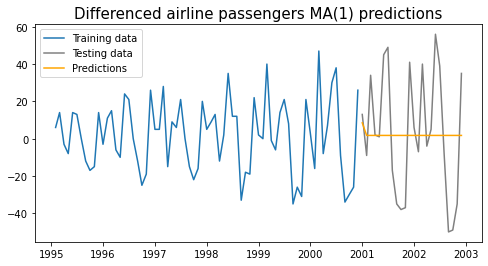

In [30]:
# Train Test Split
df_train = df[1:-24]
df_tesft = df[-24:]

# Train the model
model = ARMA(df_train['Passengers First Difference'], order=(0, 1))
results = model.fit()
predictions = results.forecast(steps=24)
predictions_df = pd.DataFrame(index=df_test.index, data=predictions[0])

# Plot
plt.figure(figsize=(8,4))
plt.title('Differenced airline passengers MA(1) predictions', size=15)
plt.plot(df_train['Passengers First Difference'], label='Training data')
plt.plot(df_test['Passengers First Difference'], color='gray', label='Testing data')
plt.plot(predictions_df, color='orange', label='Predictions')
plt.legend();

#### Autocorrelation and Partial Autocorrelation plots

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

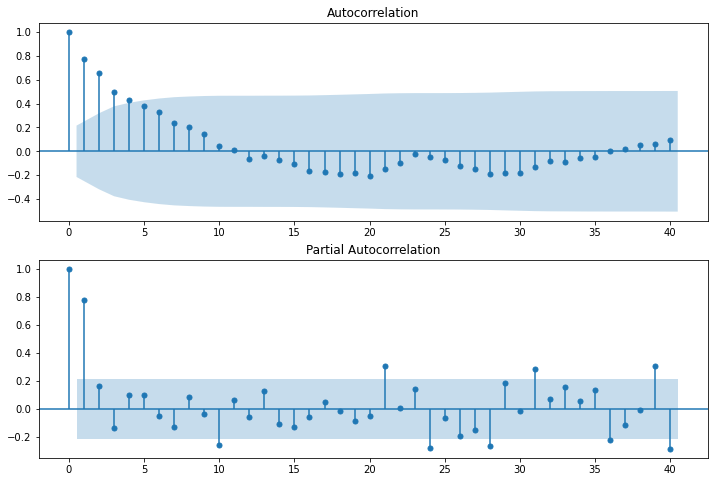

In [32]:
# Using autocorrelation plot and partial autocorrelation plot to decide p,q,d values
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

### ARIMA

In [33]:
from statsmodels.tsa.arima_model import ARIMA

# Model Building
model = ARIMA(df['Passengers'],order=(2,1,1))
fitted = model.fit()

#forecasting
df['forecast'] = fitted.predict(83,end=None)

<AxesSubplot:xlabel='Month'>

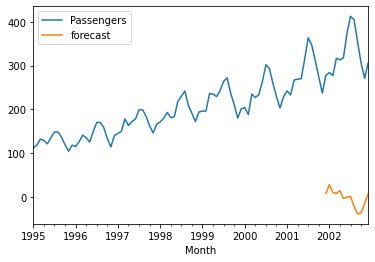

In [34]:
df[['Passengers','forecast']].plot()

### Hyperparameter Tunning 

In [35]:
from math import sqrt

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
series = pd.read_excel('Airlines+Data.xlsx', header=0, index_col=0, parse_dates=True, squeeze=True)

# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)

evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=108.427
ARIMA(0, 0, 1) RMSE=58.585
ARIMA(0, 1, 0) RMSE=31.057
ARIMA(0, 1, 1) RMSE=29.106
ARIMA(0, 1, 2) RMSE=32.280
ARIMA(0, 2, 0) RMSE=36.440
ARIMA(0, 2, 1) RMSE=31.762
ARIMA(0, 2, 2) RMSE=29.603
ARIMA(1, 0, 0) RMSE=31.507
ARIMA(1, 0, 1) RMSE=29.207
ARIMA(1, 0, 2) RMSE=75.036
ARIMA(1, 1, 0) RMSE=30.018
ARIMA(1, 1, 1) RMSE=30.169
ARIMA(1, 1, 2) RMSE=26.338
ARIMA(1, 2, 0) RMSE=36.494
ARIMA(2, 0, 0) RMSE=30.175
ARIMA(2, 1, 0) RMSE=29.124
ARIMA(2, 1, 1) RMSE=25.964
ARIMA(2, 2, 0) RMSE=34.902
ARIMA(4, 0, 0) RMSE=29.874
ARIMA(4, 1, 0) RMSE=27.773
ARIMA(4, 1, 1) RMSE=26.374
ARIMA(4, 2, 0) RMSE=32.304
ARIMA(4, 2, 1) RMSE=28.366
ARIMA(6, 0, 0) RMSE=28.793
ARIMA(6, 1, 0) RMSE=28.494
ARIMA(6, 1, 1) RMSE=26.242
ARIMA(6, 2, 0) RMSE=32.205
ARIMA(6, 2, 1) RMSE=29.084
ARIMA(8, 0, 0) RMSE=28.736
ARIMA(8, 1, 0) RMSE=24.162
ARIMA(8, 1, 1) RMSE=22.092
ARIMA(8, 2, 0) RMSE=31.123
ARIMA(8, 2, 1) RMSE=24.435
ARIMA(10, 1, 0) RMSE=16.289
ARIMA(10, 2, 0) RMSE=24.388
Best ARIMA(10, 1, 0) RMSE

### Re-building ARIMA 

<AxesSubplot:xlabel='Month'>

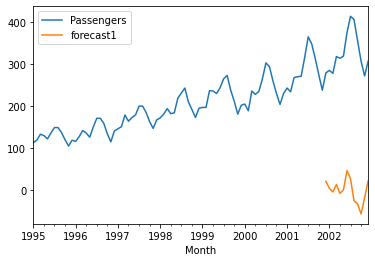

In [36]:
model1 = ARIMA(df['Passengers'],order=(10,1,0))

fitted1 = model1.fit()

df['forecast1'] = fitted1.predict(83,end=None)
df[['Passengers','forecast1']].plot()

In [44]:
test = df['Passengers'].iloc[83:,]
pred = df['forecast1'].iloc[83:,]
sqrt(mean_squared_error(test,pred))

329.942163800879

### Seasonal ARIMA

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

<AxesSubplot:xlabel='Month'>

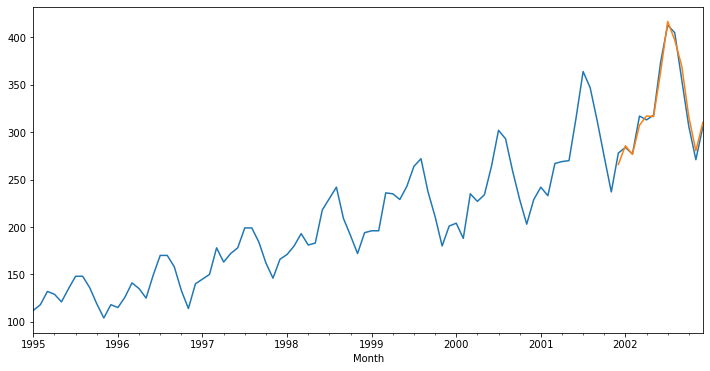

In [39]:
model2 = SARIMAX(df['Passengers'],order=(8,1,1),seasonal_order=(0, 1, 2, 4))

fitted2 = model2.fit()

df['forecast2'] = fitted2.predict(83,end=None)
plt.figure(figsize=(12,6))
df['Passengers'].plot()
df['forecast2'].plot()

In [45]:
test = df['Passengers'].iloc[83:,]
pred = df['forecast2'].iloc[83:,]
sqrt(mean_squared_error(test,pred))

8.164872255637475

<AxesSubplot:xlabel='Month'>

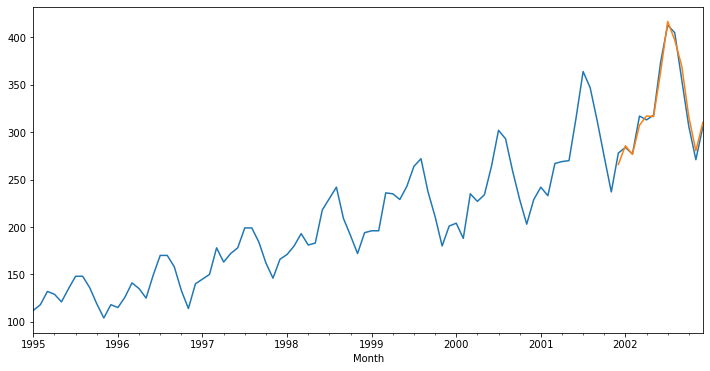

In [41]:
model3 = SARIMAX(df['Passengers'],order=(1,1,1),seasonal_order=(0, 0, 0, 12))

fitted3 = model2.fit()

df['forecast3'] = fitted3.predict(83,end=None)
plt.figure(figsize=(12,6))
df['Passengers'].plot()
df['forecast3'].plot()

In [46]:
test = df['Passengers'].iloc[83:,]
pred = df['forecast3'].iloc[83:,]
sqrt(mean_squared_error(test,pred))

8.164872255637475

We will use SARIMA model for Airlines passengers forecasting

Thank you!